In [40]:
import os
import webbrowser
import requests
from bs4 import BeautifulSoup
import pandas as pd
%pip install geocoder
%pip install geopy
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import sklearn
from sklearn.cluster import KMeans
import folium
import numpy as np
import matplotlib.pyplot as plt
%pip install selenium
from selenium import webdriver
import time
%pip install fuzzywuzzy
from fuzzywuzzy import fuzz

Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/07/e1/9c72de674d5c2b8fcb0738a5ceeb5424941fefa080bfe4e240d0bacb5a38/geopy-2.0.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8b/62/26ec95a98ba64299163199e95ad1b0e34ad3f4e176e221c40245f211e425/geographiclib-1.50-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/80/d6/4294f0b4bce4de0abf13e17190289f9d0613b0a44e5dd6a7f5ca98459853/selenium-3.141.0-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


C:\Users\linh8\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Hospital Data

In [ ]:
def get_hospital_data(lat, lng, borough, neighborhood):
    """
    We are going to utilize foursquare API to fetch hospital data. It will take latitude,     longitude and return hospital information.
    """
    radius = 1000
    LIMIT = 100
    VERSION = '20200729'
    FS_CLIENT_ID = "X5RJRX3EFCKIXZ01OTCISFLPMN5GKLSV25KEF5TVPPGIW5DD"
    FS_CLIENT_SECRET = "HFEORDBEUY2HLBRIE310WNNITLPLF1LP1R1S225GXK34RUVZ"
    FS_HOSPITAL_KEY = "4bf58dd8d48988d196941735"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_HOSPITAL_KEY)
    response = requests.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            venue_details.append(
                [venue_id, venue_name, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df = pd.DataFrame(venue_details, columns=column_names)
    return df

In [12]:
# Let us also write another function to utilize the nyc_df to get hospital data
def get_hospital_per_neighborhood_borough(df):
    """
    It will utilize NYC_DF and get hospital per neighborhood.
    """
    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df.iterrows():
        h_df = get_hospital_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    n_df = pd.DataFrame(data, columns=column_names)
    return n_df

In [13]:
nyc_df=pd.read_csv('nyc_data.csv')
nyc_df

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude,Population
0,0,Bronx,Wakefield,40.894705,-73.847201,29158
1,1,Bronx,Co-op City,40.874294,-73.829939,43752
2,2,Bronx,Fieldston,40.895437,-73.905643,3292
3,3,Bronx,Riverdale,40.890834,-73.912585,48049
4,4,Bronx,Kingsbridge,40.881687,-73.902818,10669
...,...,...,...,...,...,...
137,137,Brooklyn,Dumbo,40.703176,-73.988753,1139
138,138,Brooklyn,Homecrest,40.598525,-73.959185,44316
139,139,Queens,Middle Village,40.716415,-73.881143,37929
140,140,Brooklyn,Erasmus,40.646926,-73.948177,135619


In [14]:

# Now let us fetch hospital bed data from NYS Health Profile
def get_bed_per_hospital():
    """
    We are going to fetch data NYS Health Profile. A selenium based scrapper will be used     as it is a dynamic site. A fixed list of IDs have been used for fetching data. These      IDs are collected manualy from the website. They represent the NYC hospitals.
    """
    ROOT_URL = "https://profiles.health.ny.gov/hospital/printview/{}"
    NYM_NYC = [
        103016, 106804, 102908, 103035, 102934, 1256608, 105117, 103009, 102974, 103006, 103041, 105086, 103056, 103086, 102973,
        102970, 102950, 103074, 103008, 103007, 102985, 103012, 106809, 102937, 103068, 102944, 102995, 106803, 102916, 105109,
        102914, 102960, 103038, 106810, 106811, 102961, 102940, 102933, 103078, 254693, 103065, 103021, 103080, 103033, 102919,
        105116, 106825, 103084, 103087, 102989, 102929, 106817, 106819, 103073, 103085, 103025
    ]  # New York Metro: New York City Hospitals' IDs 
    NYM_LI = [
        102999, 103062, 102928, 103002, 102980, 103077, 103049, 103011, 102918, 102965, 102994, 102966, 103069, 1189331, 102926,
        103088, 103045, 103000, 103070, 105137, 103082, 102954, 103072
    ] # New York Metro: Long Iceland Hospitals' IDs
    BRONX = [
        102908, 106804, 105117, 102973, 102950, 106809, 102937, 103068, 102944, 103078, 103087
    ] # New York Metro: Bronx Hospitals' IDs
    QUEENS = [
        102974, 103006, 102912, 103074, 103008, 105109, 102933, 103033, 103084
    ] # New York Metro: Queens Hospitals' IDs

    HOSPITALS = list(set(NYM_LI + NYM_NYC + BRONX + QUEENS))
    print('Total hospitals', len(HOSPITALS))

    hospital_data = []

    for val in HOSPITALS:
        print("Processing hospital id", val)
        url = ROOT_URL.format(val)
        browser = webdriver.chrome()
        try:
            browser.get(url)
            time.sleep(10)
            html = browser.page_source
            soup = BeautifulSoup(html, 'html.parser')
            hospital_name = soup.find('h2').text
            table = soup.select("table", id="number-of-beds")[0]
            rows = table.findAll('tr')
            hospital_name = soup.find('h2').text.strip()
            icu_beds = 0
            for row in rows:
                tds = row.findAll('td')
                should_record = False
                for td in tds:
                    if "intensive care beds" == td.text.lower():
                        should_record = True
                        continue
                    if should_record:
                        icu_beds = td.text

            bed_number = rows[-1].findAll('td')[-1].text
            print(hospital_name, bed_number, icu_beds)
            hospital_data.append([hospital_name, bed_number, icu_beds])
        except Exception as e:
            print(e)
        browser.quit()
    df = pd.DataFrame(
        hospital_data, columns=[
            "Hospital Name", "Bed Number", "ICU Bed Number"
        ]
    )
    df = df.drop_duplicates(subset='Hospital Name', keep='last')
    df.to_csv('hospital_beds.csv')
    return df

In [15]:
def combine_hospital_beds_with_boro_neighborhood(hospital_df, hospital_boro_nei_df):
    # Uses fuzzywuzzy to match hospital name from Foursquare to NYS
    data = []
    column_names = ["Hospital Name", "Bed Number", "ICU Bed Number"]
    boro_neig_column_names = ["Borough", "Neighborhood"]
    for i, row in hospital_df.iterrows():
        data_per_hospital = None
        max_ratio = 0
        for x, hrow in hospital_boro_nei_df.iterrows():
            ratio = fuzz.token_sort_ratio(row["Hospital Name"], hrow["Name"])
            if ratio > max_ratio:
                max_ratio = ratio
                data_per_hospital = [
                    row[column] for column in column_names] + \
                    [hrow[column] for column in boro_neig_column_names
                     ]
        if data_per_hospital:
            data.append(data_per_hospital)

    df = pd.DataFrame(data, columns=column_names+boro_neig_column_names)
    df.to_csv('cleaned_hospital_data.csv')
    return df

In [16]:
h_df = pd.read_csv('cleaned_hospital_data.csv')
h_df.head()

,Unnamed: 0,Hospital Name,Bed Number,ICU Bed Number,Borough,Neighborhood
0,0,Jamaica Hospital Medical Center,402,8,Queens,Briarwood
1,1,"New York Community Hospital of Brooklyn, Inc",134,7,Brooklyn,Fort Greene
2,2,Mount Sinai Hospital,1134,85,Manhattan,East Harlem
3,3,Nassau University Medical Center,530,22,Manhattan,Turtle Bay
4,4,Richmond University Medical Center,448,20,Manhattan,Turtle Bay


In [17]:
h_df.dtypes
h_df = h_df.astype({'Bed Number': 'int32', 'ICU Bed Number': 'int32'})

In [18]:
h_df = h_df.groupby(
    ["Neighborhood", "Borough"]
).agg(
    {
        "Bed Number": "sum",
        "ICU Bed Number": "sum"
    }
)
h_df.head()

,,Bed Number,ICU Bed Number
Neighborhood,Borough,,
Bensonhurst,Brooklyn,204,8
Briarwood,Queens,671,24
Brighton Beach,Brooklyn,306,17
Brownsville,Brooklyn,600,28
Bushwick,Brooklyn,324,16


In [19]:
# Merge hospital data and New York City information data

In [20]:
df = pd.merge(h_df, nyc_df, how="inner", on=["Borough", "Neighborhood"])
df.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population
0,Brooklyn,Bensonhurst,204,8,34,40.611009,-73.995180,151705
1,Queens,Briarwood,671,24,107,40.710935,-73.811748,53877
2,Brooklyn,Brighton Beach,306,17,38,40.576825,-73.965094,35547
3,Brooklyn,Brownsville,600,28,44,40.663950,-73.910235,58300
4,Brooklyn,Bushwick,324,16,46,40.698116,-73.925258,129239


In [21]:
# add bed per 100 people data with the dataframe
def get_bed_per_hunderd_person(row, field="Bed Number"):
    """
    Will return bed per hundered data. field can be beds or icu beds
    """
    return row[field] * 100 / row["Population"]

df["ICU Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row, field="ICU Bed Number"), axis=1)

df["Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row), axis=1)

df.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People
0,Brooklyn,Bensonhurst,204,8,34,40.611009,-73.995180,151705,0.005273,0.134472
1,Queens,Briarwood,671,24,107,40.710935,-73.811748,53877,0.044546,1.245429
2,Brooklyn,Brighton Beach,306,17,38,40.576825,-73.965094,35547,0.047824,0.860832
3,Brooklyn,Brownsville,600,28,44,40.663950,-73.910235,58300,0.048027,1.029160
4,Brooklyn,Bushwick,324,16,46,40.698116,-73.925258,129239,0.012380,0.250698


In [22]:
# Add information about Covid case rate

In [23]:
covid_case_rate = pd.read_csv('data-by-modzcta.csv')
covid_case_rate.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,420,1782.45,23563.03,25,106.10,7.11,5911
1,10002,Chinatown/Lower East Side,Manhattan,1229,1601.19,76755.41,160,208.45,10.16,12102
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,515,957.22,53801.62,34,63.20,5.50,9362
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,6.13,636
4,10005,Financial District,Manhattan,79,940.91,8396.11,2,23.82,5.29,1492


In [24]:
# keep only the relevant information
covid_case_rate = covid_case_rate[['NEIGHBORHOOD_NAME', 'BOROUGH_GROUP', 'COVID_CASE_RATE']]
covid_case_rate.head()

,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_RATE
0,Chelsea/NoMad/West Chelsea,Manhattan,1782.45
1,Chinatown/Lower East Side,Manhattan,1601.19
2,East Village/Gramercy/Greenwich Village,Manhattan,957.22
3,Financial District,Manhattan,1068.32
4,Financial District,Manhattan,940.91


In [25]:
covid_rate = covid_case_rate.rename(columns={'NEIGHBORHOOD_NAME': 'Neighborhood', 'BOROUGH_GROUP': 'Borough'})
covid_rate.to_csv('covid_rate.csv')

In [26]:
covid_rate.shape

(177, 3)

In [27]:
# Merge the New York City data to the Covid case data

In [28]:
# acquire the list of the Neighborhood from geographical data and use that to match with the list of Neighborhoods from the Covid data
tocheck_list = df["Neighborhood"].tolist()
lst = [str(i) for i in tocheck_list]

In [29]:
all(isinstance(n, str) for n in tocheck_list)

True

In [30]:
# process the Neighborhoods of the Covid data
data = []
column_names = ["Neighborhood", "Borough", "COVID_CASE_RATE"]
for i,row in covid_rate.iterrows():
     for check in tocheck_list:
        if check in row['Neighborhood']:
            Neighborhood = check
            Borough = row['Borough']
            COVID_CASE_RATE = row['COVID_CASE_RATE']
            data.append([Neighborhood, Borough, COVID_CASE_RATE])
            
test_df = pd.DataFrame(data, columns=column_names)
test_df.head()
    
    

,Neighborhood,Borough,COVID_CASE_RATE
0,Chelsea,Manhattan,1782.45
1,Chinatown,Manhattan,1601.19
2,East Village,Manhattan,957.22
3,East Village,Manhattan,1346.43
4,Chelsea,Manhattan,1206.05


In [31]:
test_df.to_csv('test2.csv')
process_df = test_df.drop_duplicates(subset='Neighborhood', keep="first")
process_df.head()
process_df.shape


(36, 3)

In [32]:
# merge the two data together to obtain the final data for clustering
nyc_final = pd.merge(df, process_df, how="inner", on=["Borough", "Neighborhood"])
nyc_final.head()
nyc_final.to_csv('nyc_final.csv')

In [33]:
nyc_final.shape

(35, 11)

In [34]:
nyc_final.drop_duplicates() 

,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
0,Brooklyn,Bensonhurst,204,8,34,40.611009,-73.995180,151705,0.005273,0.134472,2705.41
1,Queens,Briarwood,671,24,107,40.710935,-73.811748,53877,0.044546,1.245429,2989.74
2,Brooklyn,Brighton Beach,306,17,38,40.576825,-73.965094,35547,0.047824,0.860832,2960.39
3,Brooklyn,Brownsville,600,28,44,40.663950,-73.910235,58300,0.048027,1.029160,2590.78
4,Brooklyn,Bushwick,324,16,46,40.698116,-73.925258,129239,0.012380,0.250698,1807.22
5,Brooklyn,Carroll Gardens,535,29,48,40.680540,-73.994654,12853,0.225628,4.162452,1235.31
6,Manhattan,Chelsea,212,12,76,40.744035,-74.003116,47325,0.025357,0.447966,1782.45
7,Manhattan,Chinatown,180,13,64,40.715618,-73.994279,47844,0.027172,0.376223,1601.19
8,Brooklyn,Crown Heights,287,13,40,40.670829,-73.943291,143000,0.009091,0.200699,2365.51
9,Manhattan,East Harlem,3906,250,69,40.792249,-73.944182,115921,0.215664,3.369536,2463.17


In [35]:
#because the case rate is per 100,000, further process to turn into per hunderd
nyc_final['COVID_CASE_RATE'] = nyc_final['COVID_CASE_RATE']/1000
nyc_final.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
0,Brooklyn,Bensonhurst,204,8,34,40.611009,-73.995180,151705,0.005273,0.134472,2.70541
1,Queens,Briarwood,671,24,107,40.710935,-73.811748,53877,0.044546,1.245429,2.98974
2,Brooklyn,Brighton Beach,306,17,38,40.576825,-73.965094,35547,0.047824,0.860832,2.96039
3,Brooklyn,Brownsville,600,28,44,40.663950,-73.910235,58300,0.048027,1.029160,2.59078
4,Brooklyn,Bushwick,324,16,46,40.698116,-73.925258,129239,0.012380,0.250698,1.80722


In [36]:
# keep only the relevant information. Because Population is already considered in case rate and ICU bed rate and bed rate, we left that out as well
nyc_clusters = nyc_final.drop(['Population','Borough', 'Neighborhood', 'Latitude', 'Longitude', 'ICU Bed Number', 'Bed Number', 'Unnamed: 0'],axis = 1)

In [41]:
# standardizing the data for clustering
nyc_clusters = sklearn.preprocessing.StandardScaler().fit_transform(nyc_clusters)
nyc_clusters

array([[-0.38106992, -0.53076213,  0.30411372],
       [-0.26449029, -0.21338984,  0.62192138],
       [-0.25475933, -0.32325946,  0.58911564],
       [-0.25415543, -0.27517262,  0.17598692],
       [-0.35997362, -0.4975591 , -0.6998312 ],
       [ 0.27304878,  0.61992908, -1.33907918],
       [-0.32145342, -0.44120471, -0.72751768],
       [-0.31606544, -0.46169998, -0.93011964],
       [-0.3697377 , -0.51184254, -0.07580688],
       [ 0.24347044,  0.39341318,  0.03335183],
       [-0.16710692,  0.01527681, -1.64991213],
       [-0.35716723, -0.44688465,  1.71426853],
       [ 0.0821292 ,  0.10824135,  0.34767213],
       [-0.29745314, -0.46272485, -0.30542467],
       [-0.0719565 ,  0.03372846, -0.69834461],
       [-0.17486449, -0.20912414, -0.70550934],
       [-0.3665083 , -0.47418824, -0.62051621],
       [-0.3418293 , -0.42522002,  2.08773975],
       [ 0.30628354,  0.71282029,  1.20360563],
       [-0.39672387, -0.28118185,  0.56489417],
       [ 5.64187853,  5.39990417, -1.021

In [42]:
# use elbow method to identify the optimal cluster number
def plot_kmeans(dataset):
    obs = dataset.copy()
    silhouette_score_values = list()
    number_of_clusters = range(3, 30)
    for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(
            obs, labels, metric='euclidean', random_state=0))

    plt.plot(number_of_clusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()

    optimum_number_of_components = number_of_clusters[silhouette_score_values.index(
        max(silhouette_score_values))]
    print("Optimal number of components is:")
    print(optimum_number_of_components)

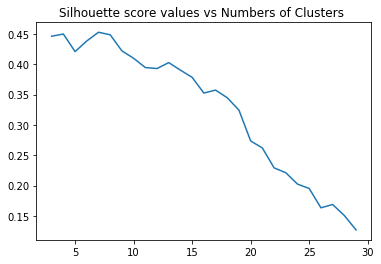

Optimal number of components is:
7


In [43]:
plot_kmeans(nyc_clusters)

In [44]:
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_clusters)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24]

array([2, 2, 2, 2, 0, 3, 0, 0, 0, 6, 3, 5, 6, 0, 0, 0, 0, 5, 4, 2, 1, 4,
       5, 2])

In [45]:
nyc_final.insert(0, 'Cluster Labels', kmeans.labels_)
nyc_final.head()

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
0,2,Brooklyn,Bensonhurst,204,8,34,40.611009,-73.995180,151705,0.005273,0.134472,2.70541
1,2,Queens,Briarwood,671,24,107,40.710935,-73.811748,53877,0.044546,1.245429,2.98974
2,2,Brooklyn,Brighton Beach,306,17,38,40.576825,-73.965094,35547,0.047824,0.860832,2.96039
3,2,Brooklyn,Brownsville,600,28,44,40.663950,-73.910235,58300,0.048027,1.029160,2.59078
4,0,Brooklyn,Bushwick,324,16,46,40.698116,-73.925258,129239,0.012380,0.250698,1.80722


In [46]:
# Exploring the clusters

In [47]:
nyc_final[(nyc_final['Cluster Labels'] == 0)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
4,0,Brooklyn,Bushwick,324,16,46,40.698116,-73.925258,129239,0.012380,0.250698,1.80722
6,0,Manhattan,Chelsea,212,12,76,40.744035,-74.003116,47325,0.025357,0.447966,1.78245
7,0,Manhattan,Chinatown,180,13,64,40.715618,-73.994279,47844,0.027172,0.376223,1.60119
8,0,Brooklyn,Crown Heights,287,13,40,40.670829,-73.943291,143000,0.009091,0.200699,2.36551
13,0,Queens,Forest Hills,312,28,89,40.725264,-73.844475,83728,0.033442,0.372635,2.16008
14,0,Brooklyn,Fort Greene,598,31,49,40.688527,-73.972906,28335,0.109405,2.110464,1.80855
15,0,Brooklyn,Gravesend,371,22,37,40.595260,-73.973471,29436,0.074738,1.260361,1.80214
16,0,Manhattan,Inwood,196,6,66,40.867684,-73.921210,58946,0.010179,0.332508,1.87818
26,0,Queens,Ridgewood,348,12,95,40.708323,-73.901435,69317,0.017312,0.502041,2.29379
29,0,Brooklyn,Sunset Park,364,24,35,40.645103,-74.010316,126000,0.019048,0.288889,1.81818


In [48]:
nyc_final[(nyc_final['Cluster Labels'] == 1)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
20,1,Manhattan,Murray Hill,2270,221,75,40.748303,-73.978332,10864,2.034242,20.894698,1.5193


In [49]:
nyc_final[(nyc_final['Cluster Labels'] == 2)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
0,2,Brooklyn,Bensonhurst,204,8,34,40.611009,-73.995180,151705,0.005273,0.134472,2.70541
1,2,Queens,Briarwood,671,24,107,40.710935,-73.811748,53877,0.044546,1.245429,2.98974
2,2,Brooklyn,Brighton Beach,306,17,38,40.576825,-73.965094,35547,0.047824,0.860832,2.96039
3,2,Brooklyn,Brownsville,600,28,44,40.663950,-73.910235,58300,0.048027,1.029160,2.59078
19,2,Bronx,Morrisania,170,0,21,40.823592,-73.901506,16863,0.000000,1.008124,2.93872
23,2,Bronx,Pelham Parkway,421,22,9,40.857413,-73.854756,30073,0.073155,1.399927,3.11771
27,2,Queens,South Ozone Park,247,11,99,40.668550,-73.809865,75878,0.014497,0.325523,2.52710
33,2,Bronx,Woodlawn,321,16,5,40.898273,-73.867315,42483,0.037662,0.755596,3.40335


In [50]:
nyc_final[(nyc_final['Cluster Labels'] == 3)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
5,3,Brooklyn,Carroll Gardens,535,29,48,40.680540,-73.994654,12853,0.225628,4.162452,1.23531
10,3,Manhattan,East Village,1296,49,78,40.727847,-73.982226,63347,0.077352,2.045874,0.95722
32,3,Brooklyn,Windsor Terrace,839,40,42,40.656946,-73.980073,20988,0.190585,3.997522,0.95807
34,3,Manhattan,Yorkville,1438,103,71,40.775930,-73.947118,35221,0.292439,4.082792,1.05381


In [51]:
nyc_final[(nyc_final['Cluster Labels'] == 4)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
18,4,Bronx,Melrose,1118,59,16,40.819754,-73.909422,24913,0.236824,4.487617,3.51015
21,4,Bronx,Norwood,1169,80,6,40.877224,-73.879391,40494,0.197560,2.886847,3.68015
28,4,Bronx,Spuyten Duyvil,306,20,27,40.881395,-73.917190,10279,0.194571,2.976943,3.07488


In [52]:
nyc_final[(nyc_final['Cluster Labels'] == 5)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
11,5,Queens,Far Rockaway,257,8,116,40.603134,-73.754980,60035,0.013326,0.428084,3.96702
17,5,Queens,Jackson Heights,545,20,85,40.751981,-73.882821,108152,0.018492,0.503920,4.30115
22,5,Bronx,Pelham Bay,225,0,28,40.850641,-73.832074,11931,0.000000,1.885844,3.93496
25,5,Queens,Queens Village,25,0,109,40.718893,-73.738715,52504,0.000000,0.047615,3.62179


In [53]:
nyc_final[(nyc_final['Cluster Labels'] == 6)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Unnamed: 0,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People,COVID_CASE_RATE
9,6,Manhattan,East Harlem,3906,250,69,40.792249,-73.944182,115921,0.215664,3.369536,2.46317
12,6,Bronx,Fordham,1029,70,13,40.860997,-73.896427,43394,0.161313,2.371296,2.74438
24,6,Brooklyn,Prospect Lefferts Gardens,2080,197,60,40.658420,-73.954899,99287,0.198415,2.094937,2.14862


In [54]:
# Visualization of the clusters

In [55]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [67]:
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
num_clusters = 4
colours=['red', 'green', 'blue', 'purple', 'white','black','cyan']
x = np.arange(num_clusters)
ys = [i+x+(i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, nei, cluster, bed_per_100_people , covid_case_rate in zip(
    nyc_final['Latitude'], nyc_final['Longitude'], nyc_final['Borough'],nyc_final['Neighborhood'], 
    nyc_final['Cluster Labels'],nyc_final['Bed Per Hundred People'], nyc_final['COVID_CASE_RATE']):
    label = folium.Popup(' Cluster ' + str(cluster)+': ' + str(bor) + "-" + str(nei) + ": "+str(round(bed_per_100_people,3)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=covid_case_rate*5,
        popup=label,
        color=colours[cluster],
        fill=True,
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       


In [68]:
map_clusters


In [69]:
map_clusters.save('cluster.html')